## Load data


In [1]:
import numpy as np 
import pandas as pd 
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
import random
BASE_IMG_PATH=os.path.join('hecktor-master','data','resampled')
BATCH_SIZE = 3
INPUT_SHAPE = (144,144,144,2)
PROJECT_NAME = 'hector'
random.seed(42)

In [2]:
glob(os.path.join(BASE_IMG_PATH,'*'))


['hecktor-master/data/resampled/CHGJ073_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ035_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ082_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS069_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ083_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS052_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM047_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ025_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS041_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS097_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS046_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS055_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHMR013_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS015_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM027_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS015_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ053_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS098_ct.nii.gz',
 'hecktor-master/data/resampled/CH

In [3]:
# show some of the files
all_ct_images= glob(os.path.join(BASE_IMG_PATH,'*ct.nii.gz'))
all_pt_images = [x.replace('ct.nii.gz', 'pt.nii.gz') for x in all_ct_images]
all_mask_images = [x.replace('ct.nii.gz', 'ct_gtvt.nii.gz') for x in all_ct_images]
np.random.seed(42)
rand_index = np.random.randint(0, len(all_ct_images))
print(len(all_ct_images),' matching files found:',all_ct_images[rand_index], all_pt_images[rand_index])
print(len(all_mask_images),' matching files found:',all_ct_images[rand_index], all_mask_images[rand_index])


201  matching files found: hecktor-master/data/resampled/CHUS074_ct.nii.gz hecktor-master/data/resampled/CHUS074_pt.nii.gz
201  matching files found: hecktor-master/data/resampled/CHUS074_ct.nii.gz hecktor-master/data/resampled/CHUS074_ct_gtvt.nii.gz


(144, 144, 144)


Text(0.5, 1.0, 'Mask')

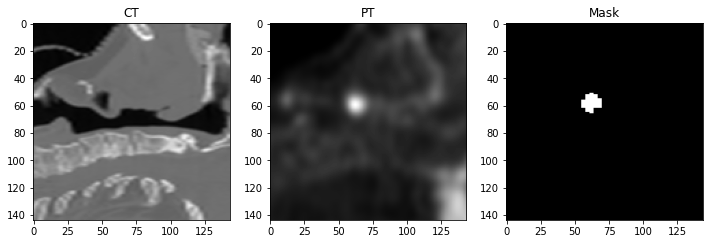

In [4]:
%matplotlib inline
try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')
    
test_ct=np.asarray(nib.load(all_ct_images[rand_index]).dataobj)
test_pt=np.asarray(nib.load(all_pt_images[rand_index]).dataobj)
test_mask=np.asarray(nib.load(all_mask_images[rand_index]).dataobj)
print(test_ct.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))

ax1.imshow(test_ct[test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(test_pt[test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')
ax3.imshow(test_mask[test_mask.shape[0]//2], cmap = 'gray')
ax3.set_title('Mask')

In [5]:
def make144(image):
    new_image = skimage.transform.resize(image, (144,144,144), mode= 'edge')
    return new_image

def preprocess(image):
    if image.shape != (144,144,144):
        image = make144(image)
    new_image = (image - image.mean())/image.std()
    
    return new_image[..., np.newaxis]
print(test_pt.max(), test_pt.min(),test_pt.shape)
new_img = preprocess(test_pt)
print(new_img.max(), new_img.min(),new_img.shape)

12.489239 -0.0050189 (144, 144, 144)
9.617565 -0.9385557 (144, 144, 144, 1)


In [6]:
data = preprocess(test_pt)
data = np.concatenate((data, preprocess(test_pt)), -1)
data.shape

(144, 144, 144, 2)

In [7]:
#check if ct, pt, mask have same numbers.

from sklearn.model_selection import train_test_split

if not len(all_ct_images) == len(all_pt_images) == len(all_mask_images):
    print(len(all_ct_images), len(all_pt_images), len(all_mask_images))
    raise ValueError('ct,pt,mask number not match')

data_list_index = range(len(all_ct_images))
train_data_list, val_data_list = train_test_split(data_list_index, test_size = 0.2, random_state = 42)


In [8]:
import tensorflow as tf


def tf_data_generator(file_list, batch_size = 2):

    i = 0
    while True:
        if i*batch_size >= len(file_list):  
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:
                _ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)
                
                img = preprocess(_ct)
                img = np.concatenate((img, preprocess(_pt)), -1)
                data.append(img) 
                
                _mask = make144(_mask)
                labels.append(_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            
batch_size = BATCH_SIZE

#tf_data_generator(train_data_list)


train_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [train_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144)))        

valid_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [val_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144))) 

#test the data generator
num = 0
for data, labels in train_dataset:
    print(data.shape, labels.shape)
    print(labels.shape)

    num = num + 1
    if num > 7: break
print("testing valid pipeline")  
for data, labels in valid_dataset:
    print(data.shape, labels.shape)

    num = num + 1
    if num > 7: break

(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
testing valid pipeline
(3, 144, 144, 144, 2) (3, 144, 144, 144)


## Densely 3D Unet

In [9]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv3D(16, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    #t = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same', data_format='channels_last')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1),strides=(2,2,1), padding='same', data_format='channels_last')(t)
    
    return t

def Tiramisu3D(layer_per_block, n_pool=4, growth_rate=16):
    input_layer = Input(shape=INPUT_SHAPE)
    t = Conv3D(48, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv3DTranspose(keep_nb_features, strides=(2,2,1), kernel_size=(3, 3, 3), padding='same', data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv3D(12, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('softmax')(t)
    return Model(inputs=input_layer, outputs=output_layer)

layer_per_block =  [3, 4, 5, 6, 7, 6, 5, 4, 3]
#layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
tiramisu = Tiramisu3D(layer_per_block)

tiramisu.summary()
#plot_model(model, to_file='model.png')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 144, 14 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 144, 144, 144 2640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 144, 144 576         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 144, 144, 144 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Attention gate input

In [10]:
PROJECT_NAME = 'hector_attention_gate'
project_name = PROJECT_NAME

def attention_block_3d(x, g, inter_channel, data_format='channels_last'):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv3D(1, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x

In [14]:
def att_input_unet(att_input= True, inter_channel = 4):
    inputs = Input(INPUT_SHAPE)
    if att_input:
        att = attention_block_3d(inputs[...,0,np.newaxis], inputs[...,1, np.newaxis], inter_channel)
        conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(att)
    else:
        conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        
    conc11 = concatenate([inputs, conv11], axis=4)
    conv12 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=4)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conc12)

    conv21 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=4)
    conv22 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conc22)

    conv31 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=4)
    conv32 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=4)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conc32)

    conv41 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=4)
    conv42 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conc42)

    conv51 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=4)
    conv52 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=4)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc52), conc42], axis=4)
    conv61 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=4)
    conv62 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=4)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc62), conv32], axis=4)
    conv71 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=4)
    conv72 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=4)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc72), conv22], axis=4)
    conv81 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=4)
    conv82 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=4)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82), conv12], axis=4)
    conv91 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=4)
    conv92 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=4)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.summary()

    return model

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
project_name = PROJECT_NAME

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def train(att_input= True, inter_channel = 4):
    batch_size = BATCH_SIZE
    project_name = PROJECT_NAME
    print(project_name)
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = att_input_unet(att_input= att_input, inter_channel = inter_channel)
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
        
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    steps_per_epoch = np.int(np.ceil(len(train_data_list )/batch_size))
    validation_steps = np.int(np.ceil(len(val_data_list)/batch_size))

    print("steps_per_epoch = ", steps_per_epoch)
    print("validation_steps = ", validation_steps)
    
    from tensorflow.keras import metrics
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss=dice_coef_loss, metrics=[metrics.binary_crossentropy, dice_coef])
    


    #model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=50, verbose=1, shuffle=True, validation_split=0.10, callbacks=[model_checkpoint, csv_logger])
    model.fit(train_dataset, validation_data = valid_dataset, steps_per_epoch = steps_per_epoch,
         validation_steps = validation_steps, epochs = 50, callbacks=[model_checkpoint, csv_logger])

    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    

In [16]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet'
train(False)


3dDenseUnet
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 323s 6s/step - loss: 0.8162 - binary_crossentropy: 0.3496 - dice_coef: 0.1842 - val_loss: 0.5002 - val_binary_crossentropy: 0.0467 - val_dice_coef: 0.5050
Epoch 2/50
54/54 [==============================] - 289s 5s/step - loss: 0.4536 - binary_crossentropy: 0.0452 - dice_coef: 0.5483 - val_loss: 0.4660 - val_binary_crossentropy: 0.0353 - val_dice_coef: 0.5405
Epoch 3/50
54/54 [==============================] - 287s 5s/step - loss: 0.3972 - binary_crossentropy: 0.0342 - dice_coef: 0.6032 - val_loss: 0.3731 - val_binary_crossentropy: 0.0234 - val_dice_coef: 0.6311
Epoch 4/50
54/54 [==============================] - 287s 5s/step - loss: 0.3577 - binary_crossentropy: 0.0311 - dice_coef: 0.6432 - val_loss: 0.3170 

54/54 [==============================] - 285s 5s/step - loss: 0.1660 - binary_crossentropy: 0.0148 - dice_coef: 0.8348 - val_loss: 0.2756 - val_binary_crossentropy: 0.0209 - val_dice_coef: 0.7280
Epoch 40/50
54/54 [==============================] - 284s 5s/step - loss: 0.1605 - binary_crossentropy: 0.0140 - dice_coef: 0.8382 - val_loss: 0.2442 - val_binary_crossentropy: 0.0182 - val_dice_coef: 0.7592
Epoch 41/50
54/54 [==============================] - 284s 5s/step - loss: 0.1872 - binary_crossentropy: 0.0159 - dice_coef: 0.8073 - val_loss: 0.2780 - val_binary_crossentropy: 0.0219 - val_dice_coef: 0.7260
Epoch 42/50
54/54 [==============================] - 283s 5s/step - loss: 0.1860 - binary_crossentropy: 0.0165 - dice_coef: 0.8146 - val_loss: 0.2997 - val_binary_crossentropy: 0.0238 - val_dice_coef: 0.7036
Epoch 43/50
54/54 [==============================] - 285s 5s/step - loss: 0.1664 - binary_crossentropy: 0.0143 - dice_coef: 0.8328 - val_loss: 0.2610 - val_binary_crossentropy: 0.0

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_att_c1'
train(True, 1 )




3dDenseUnet_att_c1
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 290s 5s/step - loss: 0.7850 - binary_crossentropy: 0.2819 - dice_coef: 0.2149 - val_loss: 0.4952 - val_binary_crossentropy: 0.0314 - val_dice_coef: 0.5105
Epoch 2/50
54/54 [==============================] - 289s 5s/step - loss: 0.4357 - binary_crossentropy: 0.0322 - dice_coef: 0.5677 - val_loss: 0.4618 - val_binary_crossentropy: 0.0279 - val_dice_coef: 0.5449
Epoch 3/50
54/54 [==============================] - 288s 5s/step - loss: 0.3930 - binary_crossentropy: 0.0314 - dice_coef: 0.6052 - val_loss: 0.4339 - val_binary_crossentropy: 0.0299 - val_dice_coef: 0.5725
Epoch 4/50
54/54 [==============================] - 288s 5s/step - loss: 0.3924 - binary_crossentropy: 0.0304 - dice_coef: 0.6091 - val_loss: 

54/54 [==============================] - 285s 5s/step - loss: 0.1677 - binary_crossentropy: 0.0151 - dice_coef: 0.8296 - val_loss: 0.2376 - val_binary_crossentropy: 0.0175 - val_dice_coef: 0.7662
Epoch 40/50
54/54 [==============================] - 286s 5s/step - loss: 0.1533 - binary_crossentropy: 0.0131 - dice_coef: 0.8475 - val_loss: 0.2291 - val_binary_crossentropy: 0.0177 - val_dice_coef: 0.7746
Epoch 41/50
54/54 [==============================] - 285s 5s/step - loss: 0.1475 - binary_crossentropy: 0.0136 - dice_coef: 0.8520 - val_loss: 0.2421 - val_binary_crossentropy: 0.0183 - val_dice_coef: 0.7615
Epoch 42/50
54/54 [==============================] - 287s 5s/step - loss: 0.1566 - binary_crossentropy: 0.0139 - dice_coef: 0.8419 - val_loss: 0.2211 - val_binary_crossentropy: 0.0172 - val_dice_coef: 0.7825
Epoch 43/50
54/54 [==============================] - 291s 5s/step - loss: 0.1544 - binary_crossentropy: 0.0125 - dice_coef: 0.8469 - val_loss: 0.2373 - val_binary_crossentropy: 0.0

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet_att_c4'
train(True, 4 )

3dDenseUnet_att_c4
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 292s 5s/step - loss: 0.8801 - binary_crossentropy: 0.4131 - dice_coef: 0.1197 - val_loss: 0.6874 - val_binary_crossentropy: 0.0893 - val_dice_coef: 0.3159
Epoch 2/50
54/54 [==============================] - 290s 5s/step - loss: 0.4944 - binary_crossentropy: 0.0431 - dice_coef: 0.5013 - val_loss: 0.4698 - val_binary_crossentropy: 0.0294 - val_dice_coef: 0.5373
Epoch 3/50
54/54 [==============================] - 289s 5s/step - loss: 0.4159 - binary_crossentropy: 0.0313 - dice_coef: 0.5833 - val_loss: 0.4516 - val_binary_crossentropy: 0.0296 - val_dice_coef: 0.5558
Epoch 4/50
54/54 [==============================] - 288s 5s/step - loss: 0.4085 - binary_crossentropy: 0.0312 - dice_coef: 0.5887 - val_loss: 

54/54 [==============================] - 286s 5s/step - loss: 0.1526 - binary_crossentropy: 0.0125 - dice_coef: 0.8459 - val_loss: 0.2575 - val_binary_crossentropy: 0.0194 - val_dice_coef: 0.7457
Epoch 40/50
54/54 [==============================] - 287s 5s/step - loss: 0.1714 - binary_crossentropy: 0.0131 - dice_coef: 0.8290 - val_loss: 0.2487 - val_binary_crossentropy: 0.0189 - val_dice_coef: 0.7552
Epoch 41/50
54/54 [==============================] - 287s 5s/step - loss: 0.1577 - binary_crossentropy: 0.0136 - dice_coef: 0.8413 - val_loss: 0.2392 - val_binary_crossentropy: 0.0178 - val_dice_coef: 0.7645
Epoch 42/50
54/54 [==============================] - 290s 5s/step - loss: 0.1436 - binary_crossentropy: 0.0119 - dice_coef: 0.8491 - val_loss: 0.2434 - val_binary_crossentropy: 0.0183 - val_dice_coef: 0.7607
Epoch 43/50
54/54 [==============================] - 288s 5s/step - loss: 0.1577 - binary_crossentropy: 0.0129 - dice_coef: 0.8430 - val_loss: 0.2465 - val_binary_crossentropy: 0.0

In [19]:
a = np.zeros((123,123,123,2))

new = a[...,1, np.newaxis]
new.shape

(123, 123, 123, 1)